In [418]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn import metrics
import xgboost as xg
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
import interpret

**3. Variable Importance for Trees and Random Forests**

(a.i) Looking at the stump in tree form, we find that the stump as a function would be 0 up until .5 and then jump to 1. Since we have binary data, the stump could jump at any point. So we could say that it's 0 until 1 and then jumps to 1 at 1. I guess it's best to do .5 in the ridiculous case where our data appears binary but actually isn't. The x-axis would be x[0]=X1. We can find the best surrogate split by hand. Doing so (see the code below this best split tree) we get that we should split on X2. This gives the exact same stump but with the x-axis equal to X2. We note that the best surrogate split is the second best split in this case.

[Text(0.5, 0.75, 'x[0] <= 0.5\ngini = 0.499\nsamples = 500\nvalue = [241, 259]'),
 Text(0.25, 0.25, 'gini = 0.241\nsamples = 243\nvalue = [209, 34]'),
 Text(0.75, 0.25, 'gini = 0.218\nsamples = 257\nvalue = [32, 225]')]

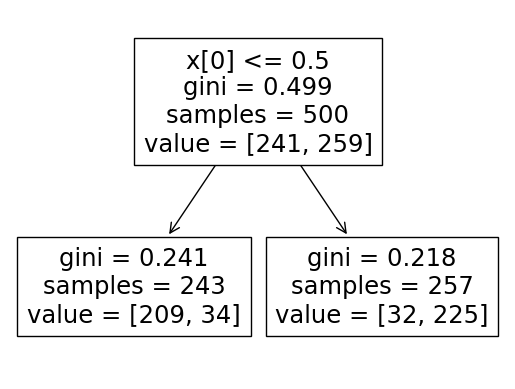

In [394]:
train = pd.read_csv("C:\\Users\\zachb\\Downloads\\train.csv")
test = pd.read_csv("C:\\Users\\zachb\\Downloads\\test.csv")

clf = sk.tree.DecisionTreeClassifier(max_depth = 1, splitter='best')
X_train, y_train, X_test, y_test = train.drop(columns=["Y"]), train["Y"], test.drop(columns=["Y"]), test["Y"] 
tree = clf.fit(X_train, y_train)
sk.tree.plot_tree(tree)

We compute using formula 4 to find the best surrogate. This also ends up being the second best split. *It turns out that X2 is the best surrogate for X1.*

In [479]:
X1 = X_train["X1"].to_numpy().reshape(-1,1)
X2 = X_train["X2"].to_numpy().reshape(-1,1)
X3 = X_train["X3"].to_numpy().reshape(-1,1)
X4 = X_train["X4"].to_numpy().reshape(-1,1)
X5 = X_train["X5"].to_numpy().reshape(-1,1)

datas = [X1, X2, X3, X4, X5]

def find_best_surrogate(x):
    maxy = 0
    best = X4
    pr = sum(x)/500
    pl = 1-pr
    min1 = min(pl, pr)
    for dt in datas:
        if (x != dt).any():
            pll = 0
            prr = 0
            for i in range(500):
                if x[i] == 0 and dt[i] == 0:
                    pll += 1/500
            for i in range(500):
                if x[i] == 1 and dt[i] == 1:
                    prr += 1/500
            val = (min1 - (1 - pll - prr))/min1
            if val >= maxy:
                maxy = val
                best = dt
    return best

 
print((X2==find_best_surrogate(X1)).all())


True


Here's the tree for the best surrogate

[Text(0.5, 0.75, 'x[0] <= 0.5\ngini = 0.499\nsamples = 500\nvalue = [241, 259]'),
 Text(0.25, 0.25, 'gini = 0.407\nsamples = 246\nvalue = [176, 70]'),
 Text(0.75, 0.25, 'gini = 0.381\nsamples = 254\nvalue = [65, 189]')]

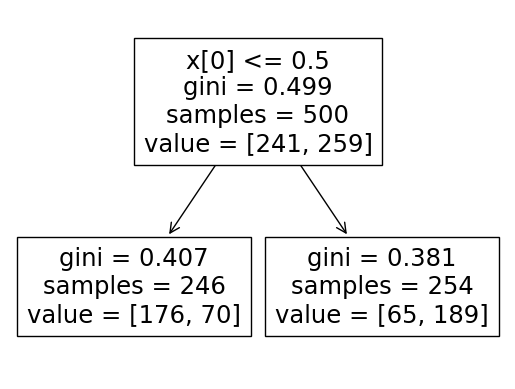

In [391]:
y = y_train.to_numpy().reshape(-1,1)
tree2 = clf.fit(X2, y)
sk.tree.plot_tree(tree2)

(ii) **Equation 2**: We only have one node. Note that I use the convention that reduction in gini is negative. We have a reduction in Gini (for splitting on X1) given by $$\text{Imp}^{\mathcal{T}}(X1)=\Delta I(s_0,j_0,0)\approx -(.499 - (\frac{243}{500}\times.241+\frac{257}{500}\times.218))\approx -.27$$
For best surrogate we get
$$\Delta I(s_0,j_0,0)\approx -(.499 - (\frac{246}{500}\times.407+\frac{254}{500}\times.381))\approx -.105$$

**Equation 3**: 
So equation 3 gives us $$\text{Imp}_s^{\mathcal{T}}(X1)\approx-.27$$
$$\text{Imp}_s^{\mathcal{T}}(X2)\approx-.105$$
This suggests that $X1$ is more important that the other variables (for this model). It also suggests that $X2$ is more important than $X3,X4,X5$ because it best approximates the best split as a surrogate.

(iii) For best split we get a mean misclassification error of $1-.9=.10$. For best surrogate we get $1-.73=.27$. We compute below.

In [395]:
# For best

print(tree.score(X_test,y_test))

# For surrogate

X = X_test["X2"].to_numpy().reshape(-1,1)
count = 0
for i in range(100):
    if X[i] == y_test[i]:
        count+=1
print(count/100)

0.9
0.73


(b) 

(i) The code below gives these results for each k. Check it out! The first dictionary is for best split and the second is for best surrogate. The following values are from a previous run of the same function. I had to reload the block so the printed values below are slightly different. I really didn't wanna copy the values into here for a third time and switch out the dicts I have in another block so forgive me for the inconsistency. 

K=1: ({'X1': 210, 'X2': 211, 'X3': 178, 'X4': 181, 'X5': 220}, {'X1': 0, 'X2': 0, 'X3': 0, 'X4': 0, 'X5': 0}) We have no surrogate splits because there's only one possible choice of feature to split on in each tree!

K=2: ({'X1': 395, 'X2': 304, 'X3': 95, 'X4': 114, 'X5': 92}, {'X1': 0, 'X2': 91, 'X3': 296, 'X4': 291, 'X5': 322})

K=3: ({'X1': 607, 'X2': 282, 'X3': 38, 'X4': 34, 'X5': 39}, {'X1': 0, 'X2': 290, 'X3': 250, 'X4': 185, 'X5': 275})

K=4 ({'X1': 783, 'X2': 217, 'X3': 0, 'X4': 0, 'X5': 0}, {'X1': 0, 'X2': 593, 'X3': 132, 'X4': 64, 'X5': 211})

K=5: ({'X1': 1000, 'X2': 0, 'X3': 0, 'X4': 0, 'X5': 0}, {'X1': 0, 'X2': 1000, 'X3': 0, 'X4': 0, 'X5': 0})

It makes sense how these results depend on K. X1 will win regardless of the sample its in so it will be best split in approximately $1000\times K/5$ trees (each feature is equally likely to be sampled). That also means that X1 will never be a best surrogate. As $K$ increases, the probability that X_i is a best split increases for lower i and decreases for higher i because as the samples get larger, the probability that a dominating split will be in the sample increases. Indeed, for large $K$ some variables are never split on i.e., they're always dominated by enough other features (even with our bootstrap; this will change as the bootstrap gets smaller). So we see gradually that we never split on X5 then never split on X4 etc. At the extreme, this means that $K=5$ makes X1 the only feature to split on for best split. For best surrogate we see a concurrent pattern. At the extreme, X2 will be the only surrogate because it's always in the sample (and always X1's surrogate). As K increases the best surrogates shift to X2. On the macro-level, the number of variables that can be best surrogates narrows as K gets larger for the same reason the best split narrows as K gets larger. 

The most important variable if we consider propensity to be the best split is X1. If we add the number of times a variable appears as a best split *and* a best surrogate split, we see that X2 is about as important as X1. This is made most clear for the K=5 case. Variable importance depends on K. Indeed, for K=1, the variables all look equally important. This is also the case for the importance heuristic of adding best and best surrogate together when K=2. In particular, # best split + # best surrogate for each X_i is about 400 for every variable when K=2. So variable importance becomes less variable (get it? ;) ) as K increases.



In [430]:
# Classifier and data init (but we bootstrap for each sample)

clf = sk.tree.DecisionTreeClassifier(max_depth = 1, splitter='best')
bs400 = train.sample(n = 400, replace=True)
train400, y400 = bs400.drop(columns = "Y"), bs400["Y"] 

# Finds best split from .feature_importances_

def best_split(importance, data):
    if 1 in importance.tolist():
        ret = importance.tolist().index(1)
        return data.columns[ret]
     
# Finds best surrogate out of the limited data. It's equivalent to maximize P_LL + P_RR.
    
def find_best_surrogate(x, data, bootstrap_size):
    split = 0
    maxy = 0
    for col in data.columns:
        val = 0
        for i in range(bootstrap_size):
            if data[x].iloc[i] == data[col].iloc[i]:
               val += 1
        if val >= maxy and col != x:
            maxy = val
            split = col 
    return split

# Creates a thousand decision trees and tells us what the best split and best surrogate split are for a given max_samples = k where we care about k = 1,...,5. Bootstap everytime.

def forest(k):
    countingbest = {"X1":0, "X2": 0, "X3": 0, "X4":0, "X5":0}
    countingsurr = {"X1":0, "X2": 0, "X3": 0, "X4":0, "X5":0}
    for i in range(1000):
        bs400 = train.sample(n = 400, replace=True)
        train400, y400 = bs400.drop(columns = "Y"), bs400["Y"] 
        sample = train400.sample(n=k, replace=False, axis = 1)
        tree = clf.fit(sample, y400)
        importances = tree.feature_importances_
        countingbest[best_split(importances,sample)] += 1
        if k != 1:
            countingsurr[find_best_surrogate(best_split(importances, sample), sample, 400)] += 1
    return countingbest, countingsurr
        
for i in range(5):
    print(forest(i+1))

({'X1': 183, 'X2': 223, 'X3': 186, 'X4': 215, 'X5': 193}, {'X1': 0, 'X2': 0, 'X3': 0, 'X4': 0, 'X5': 0})
({'X1': 388, 'X2': 292, 'X3': 98, 'X4': 125, 'X5': 97}, {'X1': 0, 'X2': 107, 'X3': 322, 'X4': 270, 'X5': 301})
({'X1': 579, 'X2': 317, 'X3': 23, 'X4': 37, 'X5': 44}, {'X1': 0, 'X2': 284, 'X3': 238, 'X4': 191, 'X5': 287})
({'X1': 815, 'X2': 185, 'X3': 0, 'X4': 0, 'X5': 0}, {'X1': 0, 'X2': 625, 'X3': 119, 'X4': 59, 'X5': 197})
({'X1': 1000, 'X2': 0, 'X3': 0, 'X4': 0, 'X5': 0}, {'X1': 0, 'X2': 1000, 'X3': 0, 'X4': 0, 'X5': 0})


(ii) Equation 5 is given by summing over trees and then adding the equation 2 impurity each time we see a tree that splits on the input feature. We get the gini values from the code blocks below (five blocks after the two below this).

Using the code below, we find the values for equation 5. I copy the dictionary here where "X_i" is a key means with value $\text{Imp}^{\mathcal{F}}(X_i)$. Note that I use the convention that the gini reduction is negative.

K=1: {'X1': -0.269093352489891, 'X2': -0.107578547981107, 'X3': -0.0017937361969648435, 'X4': -0.0019369560144408607, 'X5': -0.0013946231629738462}

K=2: {'X1': -0.27114005146602865, 'X2': -0.1049618125325611, 'X3': -0.0030029115335786735, 'X4': -0.0027396837569839097, 'X5': -0.002089123383254096}

K=3: {'X1': -0.26940099079184254, 'X2': -0.10497004303539806, 'X3': -0.003917254662012198, 'X4': -0.003685900365460322, 'X5': -0.0035807177041025317}

K=4: {'X1': -0.2705484901626932, 'X2': -0.10690779670327398, 'X3': 0, 'X4': 0, 'X5': 0}

K=5 {'X1': -0.26935325723318093, 'X2': 0, 'X3': 0, 'X4': 0, 'X5': 0}

Of course these values depend on $K$ because the number of times a feature is split on depends on $K$. In particular, the values for equation 5 are going to "concentrate" toward the more important variables (variables with lower indices) as $K$ increases. A lower (because $\Delta I$ is negative) value under equation 5 corresponds to more importance. Indeed, the equation incorporates both gini reduction and number of occurences (which depends on number of occurences). If a feature is split on more often (resp. if it reduces gini more) then that feature is more important for the model. But X2's value goes up, peaks at K=3 and then goes down. So of course large $K$ will end up with the best feature dominating, masking the others. The nice thing about this equation is that it takes gini into account. So it gives us more information than just looking at the number of times a tree is selected. This is great because it means that $K=1$ is no longer worthless.

Now we'll look at eq6 which will be computed with code in the block below the one immediately below. We get the following values (before dividing by 1000):

$K=1: {'X1': 0.348314606741573, 'X2': 0.16666666666666663, 'X3': -0.010869565217391353, 'X4': -0.04347826086956519, 'X5': 0.0}$

$K=2: {'X1': 0.28421052631578947, 'X2': 0.19999999999999996, 'X3': -0.07058823529411773, 'X4': 0.0, 'X5': 0.0}$

$K=3: {'X1': 0.37777777777777777, 'X2': 0.23655913978494625, 'X3': 0.0, 'X4': -0.01104972375690616, 'X5': -0.04469273743016755}$

$K=4: {'X1': 0.3497267759562841, 'X2': 0.2187499999999999, 'X3': 0, 'X4': 0, 'X5': 0}$

$K=5: {'X1': 0.38636363636363646, 'X2': 0, 'X3': 0, 'X4': 0, 'X5': 0}$

The interesting thing to note are the small negative values. You can get negative values when your variables have almost no predictive power. Scrambling has a non-0 probability of decreasing error and that probability is larger for bad features. We see a familiar pattern with our values: the variable importance concentrates on better features as $K$ grows. We can say that X1 and X2 are the most important variables from this as well.

**Masking does not hide as much in either of these equations as it does with decision stumps.** For equation 5, masking is less pronounced because gini plays a role. Even though we don't directly use surrogates, surrogates for important features will have higher gini and hence you can distinguish between the features even in low $K$ regimes. We notice that the variable importance ratio of X1 to X2 for K=4 is much lower than it was in just the decision stump setting. The decision stump setting gave us counts. This setting gives us errors. So it necessarily captures more of the quality of X2 relative to X1.

**I'll note that my part (iii) is way the hell down**




In [478]:
def eqn5(k):
    countingbest = {"X1":0, "X2": 0, "X3": 0, "X4":0, "X5":0}
    ans = {"X1":0, "X2": 0, "X3": 0, "X4":0, "X5":0}
    for i in range(1000):
        bs400 = train.sample(n = 400, replace=True)
        train400, y400 = bs400.drop(columns = "Y"), bs400["Y"] 
        sample = train400.sample(n=k, replace=False, axis = 1)
        tree = clf.fit(sample, y400)
        importances = tree.feature_importances_
        countingbest[best_split(importances,sample)] += 1
        var1 = tree.tree_.n_node_samples[1]/400
        var2 = tree.tree_.n_node_samples[2]/400
        delI = var1*tree.tree_.impurity[1] + var2*tree.tree_.impurity[2] - tree.tree_.impurity[0]
        ans[best_split(importances, sample)] += delI
    for key in ans:
        if countingbest[key] != 0:
            ans[key] = ans[key]/countingbest[key]
    return ans

for k in range(5):
    print(eqn5(k+1))

{'X1': -0.269093352489891, 'X2': -0.107578547981107, 'X3': -0.0017937361969648435, 'X4': -0.0019369560144408607, 'X5': -0.0013946231629738462}
{'X1': -0.27114005146602865, 'X2': -0.1049618125325611, 'X3': -0.0030029115335786735, 'X4': -0.0027396837569839097, 'X5': -0.002089123383254096}
{'X1': -0.26940099079184254, 'X2': -0.10497004303539806, 'X3': -0.003917254662012198, 'X4': -0.003685900365460322, 'X5': -0.0035807177041025317}
{'X1': -0.2705484901626932, 'X2': -0.10690779670327398, 'X3': 0, 'X4': 0, 'X5': 0}
{'X1': -0.26935325723318093, 'X2': 0, 'X3': 0, 'X4': 0, 'X5': 0}


In [432]:
clfa = sk.tree.DecisionTreeClassifier(max_depth = 1, splitter='best')

# Get the OOB for a given bootstrap sample

def oob(data, sample, bootstrap_size):
    strap = list(range(bootstrap_size))
    ooby = []
    for index in sample.index:
        if index in strap:
            strap.remove(index)
    for index in strap:
        ooby.append(data.loc[index])
    return pd.DataFrame(ooby, columns=["X1", "X2", "X3", "X4", "X5", "Y"])

oob(train, bs400, 400)

# I'm copying this over for lolz

def best_split(importance, data):
    if 1 in importance.tolist():
        ret = importance.tolist().index(1)
        return data.columns[ret]

# We modify forest from before so that we can compute eqn 6

def forest_oob(k):
    oobs = {"X1": 0, "X2":0, "X3":0, "X4":0, "X5":0}
    for i in range(1000):
        bs400 = train.sample(n = 400, replace=True)
        train400, y400 = bs400.drop(columns = "Y"), bs400["Y"] 
        sample = train400.sample(n=k, replace=False, axis = 1)
        cols = []
        for col in sample.columns:
            cols.append(col)
        tree = clfa.fit(sample, y400)
        importances = tree.feature_importances_
        best_feature = best_split(importances, sample)
        # OOB error is just 1 minus the accuracy on the OOB samples
        itshere = oob(train, bs400, 400)
        score = tree.score(itshere[cols], itshere["Y"])
        oob_error = 1 - score
        # We scramble and then recompute the error
        itshere1 = itshere
        itshere1[best_feature] = np.random.permutation(itshere[best_feature].values)
        oob_error_scram = 1 - tree.score(itshere1[cols], itshere["Y"])
        oobs[best_feature] = oob_error_scram - oob_error
    return oobs

for k in range(5):
    print(forest_oob(k+1))
        


{'X1': 0.348314606741573, 'X2': 0.16666666666666663, 'X3': -0.010869565217391353, 'X4': -0.04347826086956519, 'X5': 0.0}
{'X1': 0.28421052631578947, 'X2': 0.19999999999999996, 'X3': -0.07058823529411773, 'X4': 0.0, 'X5': 0.0}
{'X1': 0.37777777777777777, 'X2': 0.23655913978494625, 'X3': 0.0, 'X4': -0.01104972375690616, 'X5': -0.04469273743016755}
{'X1': 0.3497267759562841, 'X2': 0.2187499999999999, 'X3': 0, 'X4': 0, 'X5': 0}
{'X1': 0.38636363636363646, 'X2': 0, 'X3': 0, 'X4': 0, 'X5': 0}


[Text(0.5, 0.75, 'x[0] <= 0.5\ngini = 0.5\nsamples = 400\nvalue = [203, 197]'),
 Text(0.25, 0.25, 'gini = 0.2\nsamples = 195\nvalue = [173, 22]'),
 Text(0.75, 0.25, 'gini = 0.25\nsamples = 205\nvalue = [30, 175]')]

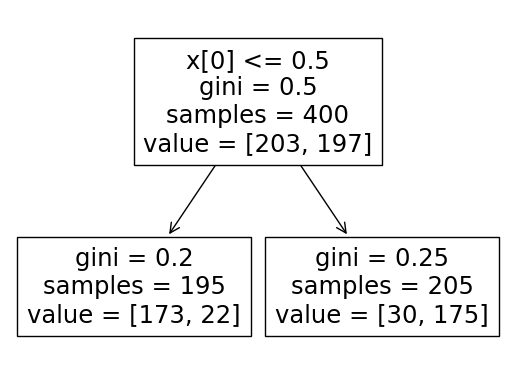

In [381]:
treea = clf.fit(train400["X1"].to_numpy().reshape(-1,1), y400)
sk.tree.plot_tree(treea)

[Text(0.5, 0.75, 'x[0] <= 0.5\ngini = 0.5\nsamples = 400\nvalue = [203, 197]'),
 Text(0.25, 0.25, 'gini = 0.383\nsamples = 182\nvalue = [135, 47]'),
 Text(0.75, 0.25, 'gini = 0.429\nsamples = 218\nvalue = [68, 150]')]

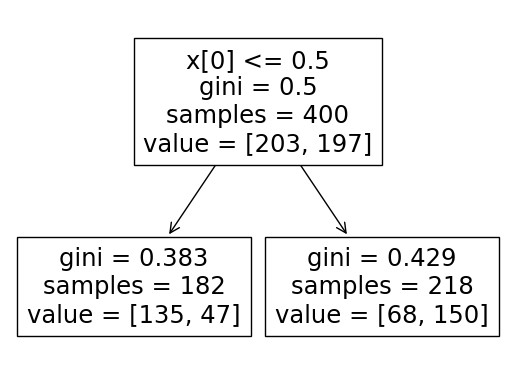

In [382]:
treeb = clf.fit(train400["X2"].to_numpy().reshape(-1,1), y400)
sk.tree.plot_tree(treeb)

[Text(0.5, 0.75, 'x[0] <= 0.5\ngini = 0.5\nsamples = 400\nvalue = [203, 197]'),
 Text(0.25, 0.25, 'gini = 0.495\nsamples = 246\nvalue = [135, 111]'),
 Text(0.75, 0.25, 'gini = 0.493\nsamples = 154\nvalue = [68, 86]')]

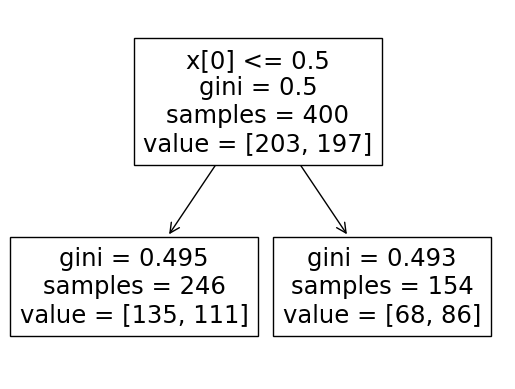

In [383]:
treec = clf.fit(train400["X3"].to_numpy().reshape(-1,1), y400)
sk.tree.plot_tree(treec)

[Text(0.5, 0.75, 'x[0] <= 0.5\ngini = 0.5\nsamples = 400\nvalue = [203, 197]'),
 Text(0.25, 0.25, 'gini = 0.496\nsamples = 197\nvalue = [107, 90]'),
 Text(0.75, 0.25, 'gini = 0.499\nsamples = 203\nvalue = [96, 107]')]

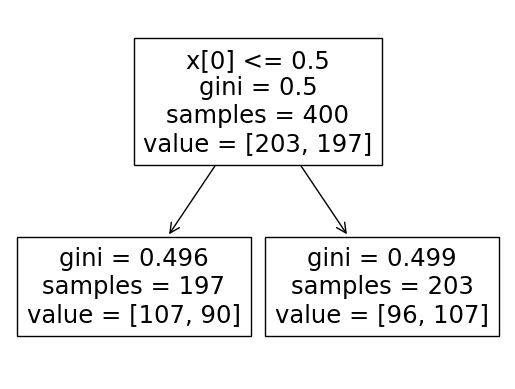

In [384]:
treed = clf.fit(train400["X4"].to_numpy().reshape(-1,1), y400)
sk.tree.plot_tree(treed)

[Text(0.5, 0.75, 'x[0] <= 0.5\ngini = 0.5\nsamples = 400\nvalue = [203, 197]'),
 Text(0.25, 0.25, 'gini = 0.5\nsamples = 187\nvalue = [96, 91]'),
 Text(0.75, 0.25, 'gini = 0.5\nsamples = 213\nvalue = [107, 106]')]

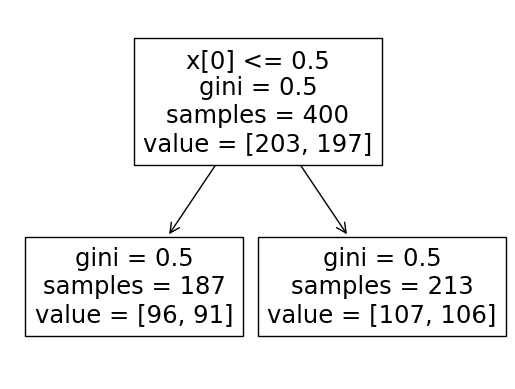

In [385]:
treee = clf.fit(train400["X5"].to_numpy().reshape(-1,1), y400)
sk.tree.plot_tree(treee)

(iii) Here are the values where the first in the pair is the loss considering individual trees while the second is considering the forest as a whole:

K=1: (0.37126999999999855, 0.2700000000000001)

K=2: (0.27971000000000007, 0.16)

K=3: (0.1919599999999987, 0.09999999999999999)

K=4: (0.13501999999999775, 0.09999999999999999)

K=5: (0.09999999999999859, 0.09999999999999999)


 Considering loss as a forest makes the model appear much better. It's also the correct way to do the loss because the model actually classifies based on the overall vote. In particular, we want to know what the misclassification error of the overall vote is, not the error for individual trees. Otherwise we wouldn't using a forest. As K increases,the "considering each tree" loss decreases much faster than the forest loss does. It then gets quite close to the forest loss for K=4,5. This makes sense because the forest result will be pretty much the same as the individual approach if we allow for splitting on the best each time (X1 and X2 are much better than X3, X4, and X5 and bootstrapping can only make them so equal). 

In [472]:
def lossforest(k):
    indivlosses= []
    aggregateloss = {}
    for index in X_test.index:
            aggregateloss[index] = 0
    for i in range(1000):
        bs400 = train.sample(n = 400, replace=True)
        train400, y400 = bs400.drop(columns = "Y"), bs400["Y"] 
        sample = train400.sample(n = k, replace=False, axis = 1)
        cols = []
        for col in sample.columns:
            cols.append(col)
        tree = clf.fit(sample, y400)
        lossindiv = 1-tree.score(X_test[cols],y_test)
        indivlosses.append(lossindiv)
        importances = tree.feature_importances_
        best = best_split(importances,sample)
        for index in X_test.index:
            if best != None:
                aggregateloss[index] += X_test.loc[index][best]
    firs = (1/1000)*sum(indivlosses)
    for key in aggregateloss:
        if aggregateloss[key] >= 500:
            aggregateloss[key] = 1
        else:
            aggregateloss[key] = 0
    aggloss = 0
    for key in aggregateloss:
        if aggregateloss[key] != y_test[key]:
            aggloss += 1/100
    return firs, aggloss

for k in [1,2,3,4,5]:
    print(lossforest(k))

(0.37126999999999855, 0.2700000000000001)
(0.27971000000000007, 0.16)
(0.1919599999999987, 0.09999999999999999)
(0.13501999999999775, 0.09999999999999999)
(0.09999999999999859, 0.09999999999999999)


(c)(i) Note again the negative gini reduction convention.
Eq5:

.4: {'X1': -0.2727228598878163, 'X2': -0.10733685747142888, 'X3': -0.004225434701865528, 'X4': -0.004512566120385943, 'X5': -0.004616510702530759}

.5: {'X1': -0.26731985464782343, 'X2': -0.10758283622850105, 'X3': -0.004127561448148088, 'X4': -0.0038601309866738306, 'X5': -0.0034426240226984478}

.6: {'X1': -0.26669619683831686, 'X2': -0.10744536044037462, 'X3': -0.004229884209347612, 'X4': -0.0028056447521050336, 'X5': -0.0027456381593072197}

.7: {'X1': -0.2685317497157445, 'X2': -0.10608240367157601, 'X3': -0.003013696297796982, 'X4': -0.003217015641501347, 'X5': -0.0027294862529029526}

.8: {'X1': -0.271081422395886, 'X2': -0.10650412357832498, 'X3': -0.0029392966099006544, 'X4': -0.0027436056732215246, 'X5': -0.0022851337138849407}


Eq6:

.4: {'X1': 0.3677692994189025, 'X2': 0.20005936980169645, 'X3': 0.0020534540755315447, 'X4': -0.009370102668138107, 'X5': -0.0019241625281042132}

.5: {'X1': 0.3626309831481122, 'X2': 0.17711030382719586, 'X3': 0.0012609818513096283, 'X4': -0.002025908160273229, 'X5': -0.007019505085167503}

.6: {'X1': 0.3572585154725405, 'X2': 0.1851266868789801, 'X3': 0.0005299591983159352, 'X4': -0.008036448153095807, 'X5': -0.008383084744897202}

.7: {'X1': 0.35514386913651674, 'X2': 0.20543482287830073, 'X3': -0.010666067891261044, 'X4': -0.00834641897630383, 'X5': -0.011236190344061094}

.8: {'X1': 0.3611829221180481, 'X2': 0.2124511435234379, 'X3': 0.0050439363785911625, 'X4': -0.005723050404540063, 'X5': -0.009128357989355186}

We notice that the values for Eq5 and Eq6 don't really depend on the bootstrap size. The bootstrap samples would have to be pretty small to see an effect here. E.g., with a super small size we might see X5 be better than X1.

In [475]:
# Eqn 5

def bestkdelta(b):
    countingbest = {"X1":0, "X2": 0, "X3": 0, "X4":0, "X5":0}
    ans = {"X1":0, "X2": 0, "X3": 0, "X4":0, "X5":0}
    for i in range(1000):
        bs400 = train.sample(n = b, replace=True)
        train400, y400 = bs400.drop(columns = "Y"), bs400["Y"] 
        sample = train400.sample(n=2, replace=False, axis = 1)
        tree = clfa.fit(sample, y400)
        importances = tree.feature_importances_
        countingbest[best_split(importances,sample)] += 1
        var1 = tree.tree_.n_node_samples[1]/b
        var2 = tree.tree_.n_node_samples[2]/b
        delI = var1*tree.tree_.impurity[1] + var2*tree.tree_.impurity[2] - tree.tree_.impurity[0]
        ans[best_split(importances, sample)] += delI
    for key in ans:
        ans[key] = ans[key]/countingbest[key]
    return ans

for b in [200,250,300,350,400]:
    print(bestkdelta(b))



# def eqn5(best, deltas):
#     ret = {"X1":0,"X2":0,"X3":0,"X4":0,"X5":0}
#     for col in train400.columns:
#         if ()
#         ret[col] = (1/1000)*best[col]*deltaI[col]
#     return ret

# for k in range(5):
#     print(eqn5(k+1))

{'X1': -0.2727228598878163, 'X2': -0.10733685747142888, 'X3': -0.004225434701865528, 'X4': -0.004512566120385943, 'X5': -0.004616510702530759}
{'X1': -0.26731985464782343, 'X2': -0.10758283622850105, 'X3': -0.004127561448148088, 'X4': -0.0038601309866738306, 'X5': -0.0034426240226984478}
{'X1': -0.26669619683831686, 'X2': -0.10744536044037462, 'X3': -0.004229884209347612, 'X4': -0.0028056447521050336, 'X5': -0.0027456381593072197}
{'X1': -0.2685317497157445, 'X2': -0.10608240367157601, 'X3': -0.003013696297796982, 'X4': -0.003217015641501347, 'X5': -0.0027294862529029526}
{'X1': -0.271081422395886, 'X2': -0.10650412357832498, 'X3': -0.0029392966099006544, 'X4': -0.0027436056732215246, 'X5': -0.0022851337138849407}


In [474]:
# Eqn 6

def forest_oob(k, b):
    oobs = {"X1": 0, "X2":0, "X3":0, "X4":0, "X5":0}
    counter = {"X1": 0, "X2":0, "X3":0, "X4":0, "X5":0}
    for i in range(1000):
        bs400 = train.sample(n = b, replace=True)
        train400, y400 = bs400.drop(columns = "Y"), bs400["Y"] 
        sample = train400.sample(n=k, replace=False, axis = 1)
        cols = []
        for col in sample.columns:
            cols.append(col)
        tree = clfa.fit(sample, y400)
        importances = tree.feature_importances_
        best_feature = best_split(importances, sample)
        counter[best_feature] += 1
        # OOB error is just 1 minus the accuracy on the OOB samples
        itshere = oob(train, bs400, b)
        score = tree.score(itshere[cols], itshere["Y"])
        oob_error = 1 - score
        # We scramble and then recompute the error
        itshere1 = itshere
        itshere1[best_feature] = np.random.permutation(itshere[best_feature].values)
        oob_error_scram = 1 - tree.score(itshere1[cols], itshere["Y"])
        oobs[best_feature] += oob_error_scram - oob_error
    for key in oobs:
        oobs[key] = oobs[key]/counter[key]
    return oobs

for b in [200,250,300,350,400]:
    print(forest_oob(2, b))

{'X1': 0.3677692994189025, 'X2': 0.20005936980169645, 'X3': 0.0020534540755315447, 'X4': -0.009370102668138107, 'X5': -0.0019241625281042132}
{'X1': 0.3626309831481122, 'X2': 0.17711030382719586, 'X3': 0.0012609818513096283, 'X4': -0.002025908160273229, 'X5': -0.007019505085167503}
{'X1': 0.3572585154725405, 'X2': 0.1851266868789801, 'X3': 0.0005299591983159352, 'X4': -0.008036448153095807, 'X5': -0.008383084744897202}
{'X1': 0.35514386913651674, 'X2': 0.20543482287830073, 'X3': -0.010666067891261044, 'X4': -0.00834641897630383, 'X5': -0.011236190344061094}
{'X1': 0.3611829221180481, 'X2': 0.2124511435234379, 'X3': 0.0050439363785911625, 'X4': -0.005723050404540063, 'X5': -0.009128357989355186}


**4. GAM**

In [30]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC

df = pd.read_csv("C:\\Users\\zachb\\Downloads\\penguins_trunc.csv")
df = df.sample(frac=1).reset_index(drop=True)
y = df["Species"]
X = df.drop(columns=["Species"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
ebm = ExplainableBoostingClassifier()
model = ebm.fit(X_train, y_train)


The accuracy for the train set is 1

In [33]:
score = model.score(X_train, y_train)
print(score)

1.0


The accuracy for the test set is incredible:

In [37]:
score = model.score(X_test, y_test)
print(score)

0.9710144927536232


We note that on Ed #359 "Q4 EBM Clarification" we find that the shape function is given by model.explain_global(). Below I have the information from model.explain_global as pictures imported into the document

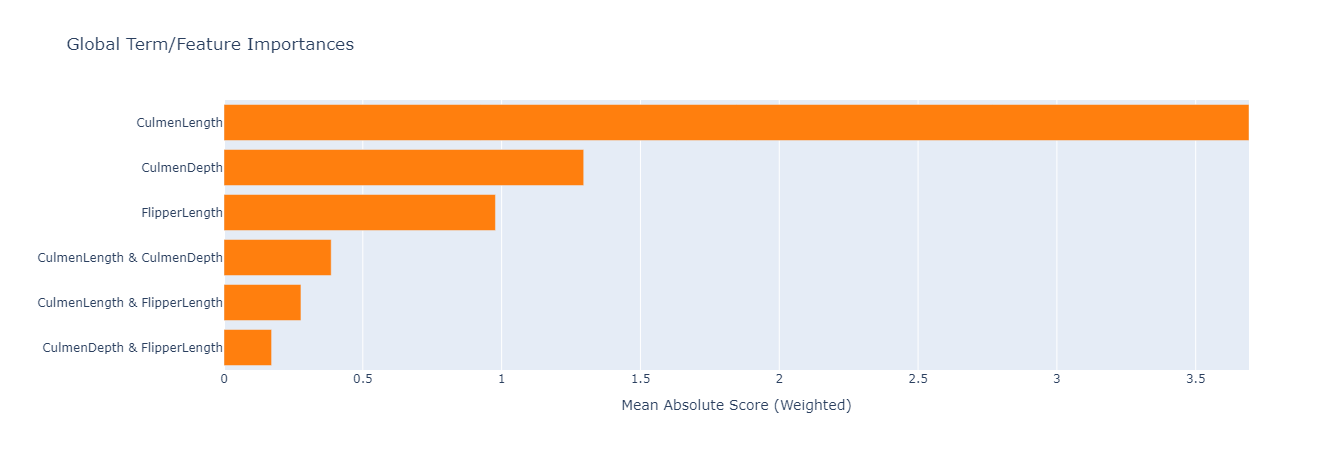

In [10]:
from IPython.display import Image
Image(filename="C:\\Users\\zachb\\Desktop\\2023-2024\\CS671\\HW 3\\GAM\\Summary.png")


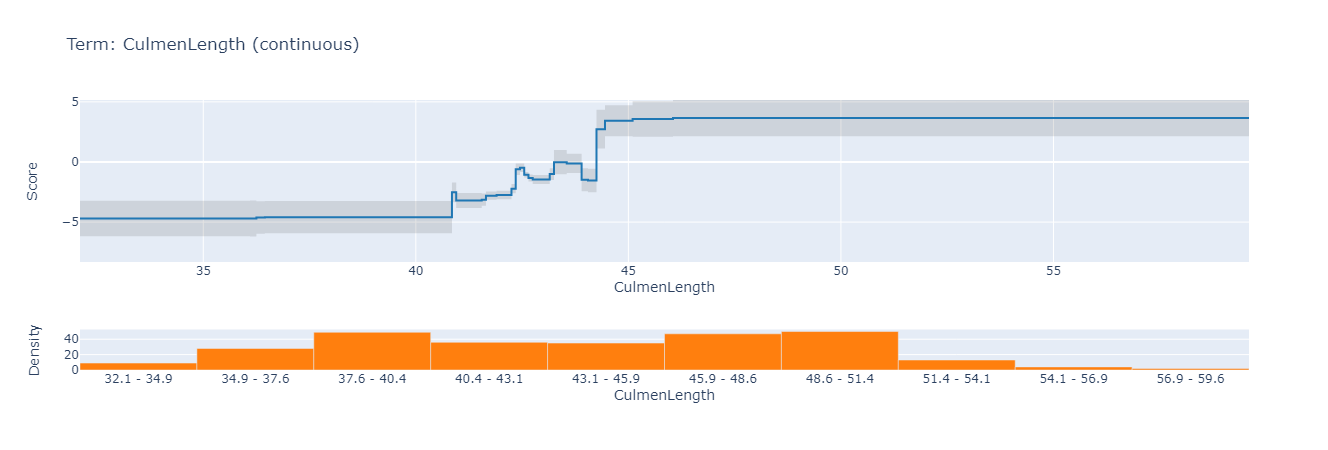

In [11]:
Image(filename="C:\\Users\\zachb\\Desktop\\2023-2024\\CS671\\HW 3\\GAM\\CulmenLength.png")

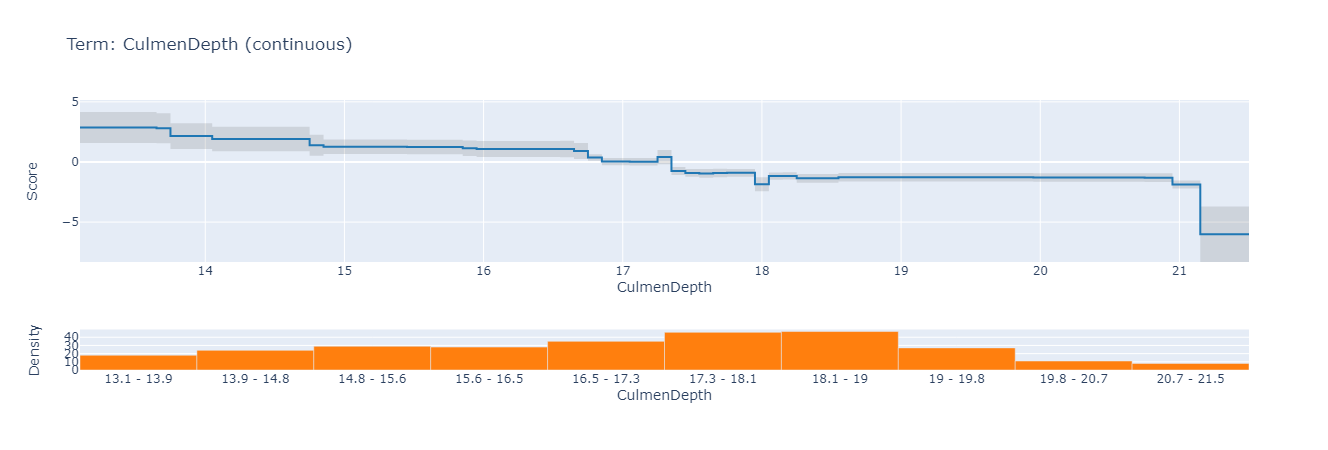

In [12]:
Image(filename="C:\\Users\\zachb\\Desktop\\2023-2024\\CS671\\HW 3\\GAM\\CulmenDepth.png")

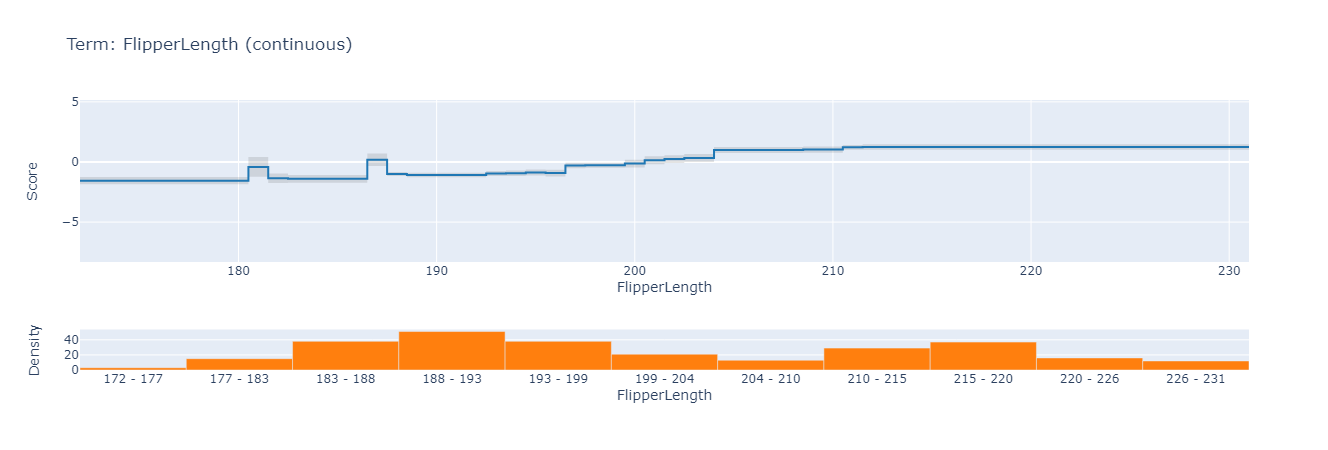

In [13]:
Image(filename="C:\\Users\\zachb\\Desktop\\2023-2024\\CS671\\HW 3\\GAM\\FlipperLength.png")

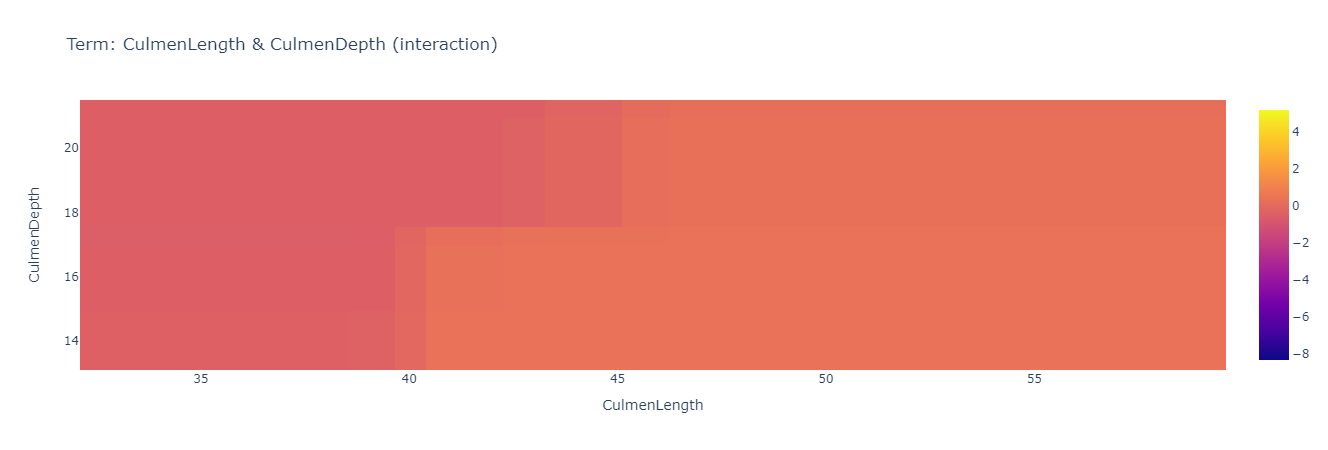

In [14]:
Image(filename="C:\\Users\\zachb\\Desktop\\2023-2024\\CS671\\HW 3\\GAM\\Length-Depth Interaction.png")

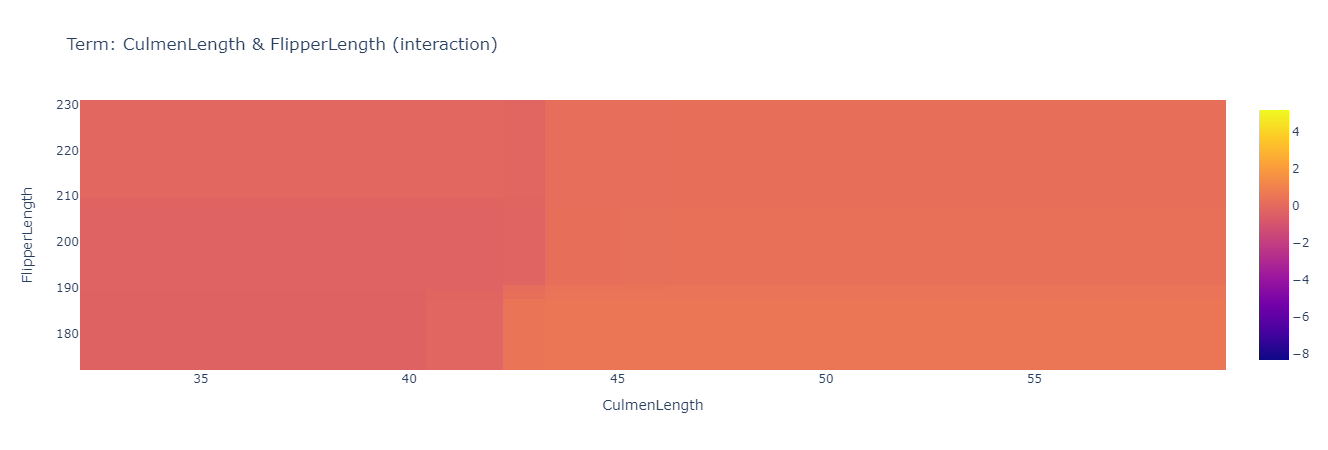

In [15]:
Image(filename="C:\\Users\\zachb\\Desktop\\2023-2024\\CS671\\HW 3\\GAM\\CulmenLength-FlipperLength Interaction.png")

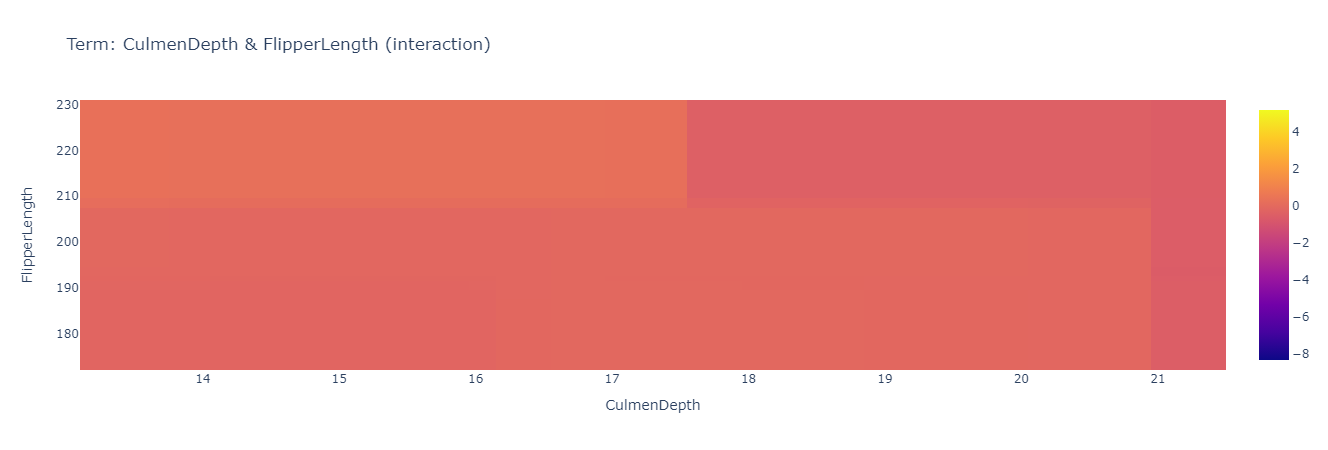

In [16]:
Image(filename="C:\\Users\\zachb\\Desktop\\2023-2024\\CS671\\HW 3\\GAM\\CulmenDepth-FlipperLength Interaction.png")

**5. Boosting Algorithm Practice**

*(a)*

In [44]:
data = pd.read_csv("C:\\Users\\zachb\\Downloads\\Titanic(1).csv")
# data.isnull().values.any()
for col in data.columns:
    if data[col].isnull().values.any():
        data = data.drop(columns=[col])

data["Sex"] = data["Sex"].replace({'male': 0, 'female': 1})
y = data["Survived"]
X = data.drop(columns=["Survived"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


*(b)* We fix max_depth = 1. We find that the accuracy of XG is marginally better (.8 compared to .78). We also note that XG runs much faster (at least on my machine).

First we do Ada. We compute the accuracy yielding ~.78

In [64]:
parameters = {'n_estimators' : [50,100,150,200,250], 'learning_rate':[.5, 1.0, 1.5, 2.0, 5.0, 10.0]}
clf = GridSearchCV(AdaBoostClassifier(), parameters, cv = 5)
best_params = clf.fit(X_train, y_train)
model = AdaBoostClassifier(**best_params.best_params_)
tree = model.fit(X_train, y_train)
score = tree.score(X_test, y_test)
score


0.7821229050279329

Now we do XG and get an accuracy of ~.8

In [63]:
parameters = {'max_depth':[1],'n_estimators' : [50,100,150,200,250], 'learning_rate':[.5, 1.0, 1.5, 2.0, 5.0, 10.0]}
clf = GridSearchCV(xg.XGBClassifier(), parameters, cv = 5)
best_params = clf.fit(X_train, y_train)
model = xg.XGBClassifier(**best_params.best_params_)
tree = model.fit(X_train, y_train)
score = tree.score(X_test, y_test)
score

0.8044692737430168